# QDockBank with VQE implementation on Simulator(First) then ionQ when possible

Most of this code is take from IBM tutorial's ground state Energy estimation of Heisenberg chain  
<https://quantum.cloud.ibm.com/docs/en/tutorials/spin-chain-vqe>  
**Reason:** Gives a base code for the VQE and the main difference between one VQE to another is only the Hamiltonian used to describe the constraints, so here only implementing the Hamiltonians described in the QDock paper => $H = Hc + Hg + Hcol + Hint$


In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.optimize import minimize
from typing import Sequence

from qiskit import QuantumCircuit
from qiskit.quantum_info import SparsePauliOp

from qiskit.primitives.base import BaseEstimatorV2
from qiskit.circuit.library import XGate
from qiskit.circuit.library import efficient_su2
from qiskit.transpiler import PassManager
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager
from qiskit.transpiler.passes.scheduling import (
    ALAPScheduleAnalysis,
    PadDynamicalDecoupling,
)

from qiskit_aer import AerSimulator
from qiskit.transpiler import CouplingMap
from qiskit import transpile

from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import Session, Estimator
from qiskit.primitives import StatevectorEstimator as Estimator

import itertools


In [3]:
def visualize_results(results):
    plt.plot(results['cost_history'], lw = 2)
    plt.xlabel("iteration")
    plt.ylabel("Energy")
    plt.show()

In [4]:
def build_callback(ansatz: QuantumCircuit, hamiltonian: SparsePauliOp, estimator: BaseEstimatorV2, callback_dict: dict, ):
    def callback(current_vector):
        # no of iterations keep track
        callback_dict['iters'] += 1

        callback_dict['prev_vector'] = current_vector

        current_cost = (estimator.run([(ansatz, hamiltonian, [current_vector])]).result()[0].data.evs[0])

        callback_dict['cost_history'].append(current_cost)

        print("Iters. done: {} [Current cost: {}]".format(callback_dict['iters'], current_cost), 
        end='\r', flush = True,)
    return callback

In [5]:
num_residue = 2
num_spins = num_residue * 4
ansatz = efficient_su2(num_qubits = num_spins, reps = 3)

backend = AerSimulator()

coupling = CouplingMap.from_full(num_spins)
reduced_coupling = coupling.reduce(list(range(num_spins)))

edge_list = reduced_coupling.graph.edge_list()

-----

# Implementing the Hc or the QUBO One-hot constraint

### Links to sources for learning the math:   
Learn QUBO:  
&nbsp;<https://oaciss.uoregon.edu/icpp21/views/includes/files/dads_pap103s3-file2.pdf>  
Learn QUBO to ising Hamiltonian:  
&nbsp;<https://quantumcomputing.stackexchange.com/questions/11663/how-to-convert-qubo-problem-to-ising-hamiltonian>  
Theory behind VQE, qiskit Textbook:   
&nbsp;<https://github.com/Qiskit/textbook/blob/main/notebooks/ch-applications/vqe-molecules.ipynb>

### Actual math done for the one_hot_constraint
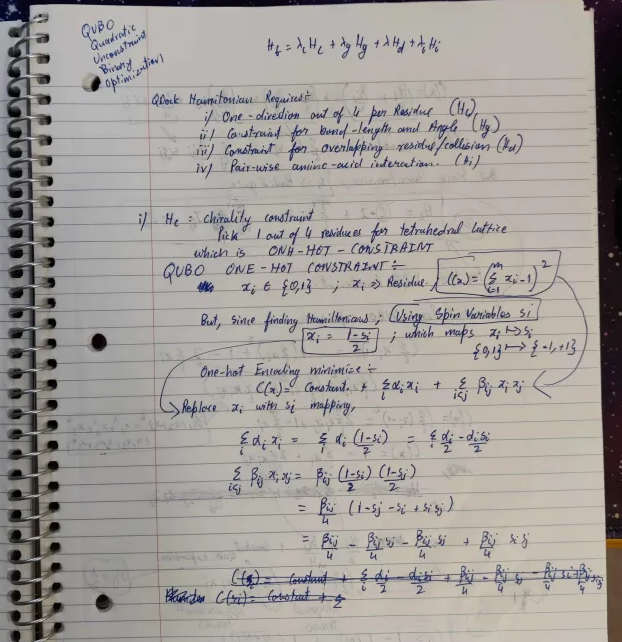
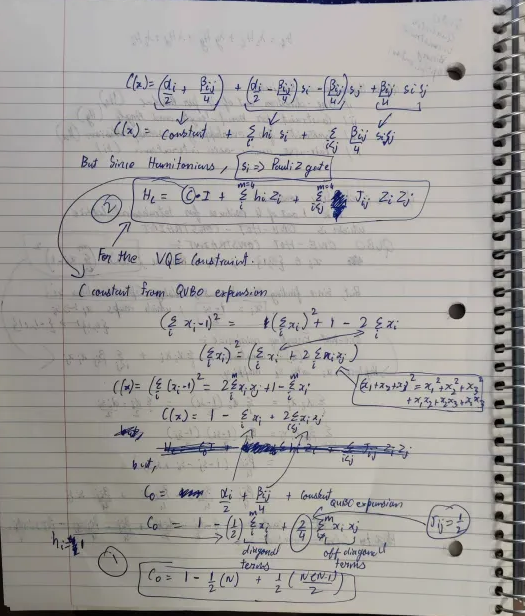

In [6]:
def one_hot_constraint(num_residue:int):
    # Hc = lambda_c * (C0* I + (sum,m=4(hi*ZI)) + (sum,m=4; i!=j (Jij * ZiZj)))

    lambda_c = 30.0 # the higher the better
    
    n = 4 # no of binary options
          # each has 4 residues

    # total qubit
    num_qubits = n * num_residue

    # form the calculated c0
    C0 = 1 - ((0.5) * n) +((0.25) * n * (n-1))

    hi = 1
    Jij = 0.5

    pauli_Op = [] # list of all sparcePauliOp
    coeffs = [] # corresponding coefficients to the paulis

    # implementing first part of Hc
    # Hc = lambda_c * (C0* I + (sum,m=4(hi*ZI)) + (sum,m=4; i!=j (Jij * ZiZj)))
    # implementing lambda_c*(C0 * I )

    
    # for i in range(num_qubits):
    #     pauli_Op.append('I')
    #     coeffs.append(C0 * lambda_c)
    pauli_Op.append('I' * num_qubits)
    coeffs.append(C0 * lambda_c)

    # implementing second part of Hc
    # Hc = lambda_c * (C0* I + (sum,m=4(hi*ZI)) + (sum,m=4; i!=j (Jij * ZiZj)))
    # implementing lambda_c*(sum,m=4(hi*ZI))
    # need to set constraint for each of the 4 residue
    for i in range(num_residue):

        base_residue = i * n # where n = 4 for the tetrahedral latice

        # if qubit = 0, then 0,1,2,3 is a part of 1 base protien with 4 residue
        # if qubit  = 1, then 1,2,3,4 is a part of 2nd base protien with 4 residue
        qubit_each_residue = []
        for j in range(n):
            qubit_each_residue.append(base_residue + j)

            

        # Hc = lambda_c * (C0* I + (sum,m=4(hi*ZI)) + (sum,m=4; i!=j (Jij * ZiZj)))
        # implementing lambda_c*(sum,m=4(hi*ZI))

        for k in qubit_each_residue: # (sum,m=4(hi*ZI)

            pauli = [] # temporary list for Is and Zs gates, to then join into pauli_Op
            
                # must do Identity matrix on all other qubits
                # and only have pauli-Z on the specific qubit
                # I (tensorProd) Z on all qubits relative to the current
            pauli = ['I'] * num_qubits
            # for l in range(num_qubits):
            #     pauli.append('I')
                
            pauli[k] = 'Z'
            pauli_Op.append(''.join(pauli))
            coeffs.append(lambda_c * hi)



        # Hc = lambda_c * (C0* I + (sum,m=4(hi*ZI)) + (sum,m=4; i!=j (Jij * ZiZj)))
        # implementing lambda_c*(sum,m=4; i!=j (Jij * ZiZj))
        
        for a,b in itertools.combinations(qubit_each_residue, 2):
            pauli = []
                # must do Identity matrix on all other qubits
                # and only have pauli-Z on the specific qubit
                # I (tensorProd) Z on all qubits relative to the current
            pauli = ['I'] * num_qubits

            pauli[a] = 'Z'
            pauli[b] = 'Z'

            pauli_Op.append(''.join(pauli))
            coeffs.append(lambda_c * Jij)


    return SparsePauliOp.from_list(list(zip(pauli_Op,coeffs)))

In [7]:
hc = one_hot_constraint(1)
print(hc)

SparsePauliOp(['IIII', 'ZIII', 'IZII', 'IIZI', 'IIIZ', 'ZZII', 'ZIZI', 'ZIIZ', 'IZZI', 'IZIZ', 'IIZZ'],
              coeffs=[60.+0.j, 30.+0.j, 30.+0.j, 30.+0.j, 30.+0.j, 15.+0.j, 15.+0.j, 15.+0.j,
 15.+0.j, 15.+0.j, 15.+0.j])


------

# Implementing the Hg or geometric constraint

### Actual math done for the Geometric constraint
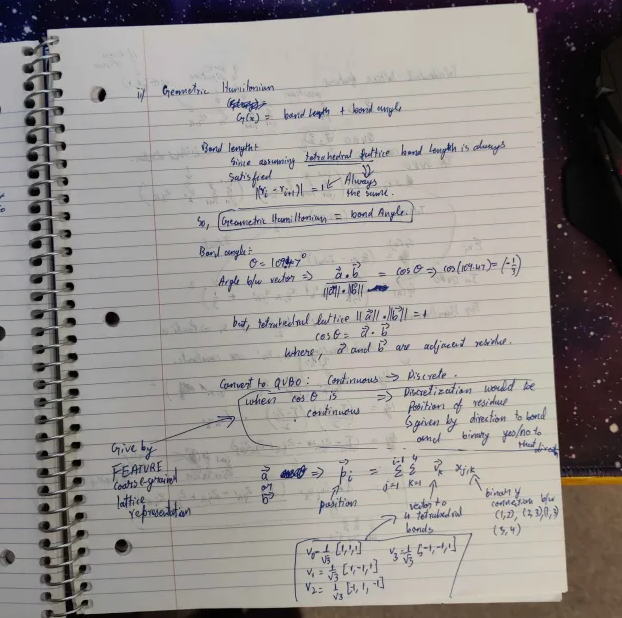
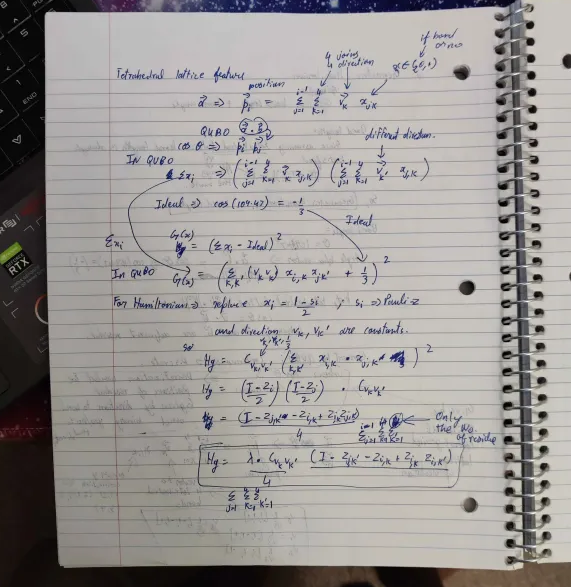
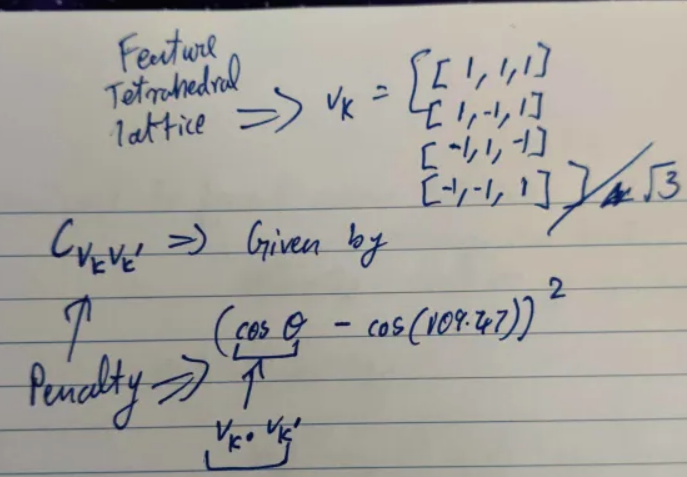

In [8]:
v = [
        np.array([1,1,1])/np.sqrt(3),
        np.array([1,-1,1])/np.sqrt(3),
        np.array([-1,1,-1])/np.sqrt(3),
        np.array([-1,-1,1])/np.sqrt(3)
    ]

In [9]:
def geometric_constraint(num_residue:int):  # ( sum 3, j = 1; sum 4, k = 1)
                                            # input needs to be a multiple of 4
                                            # if 10 residue then num_qubits = 40

    # PENALTY MATRIX FOR v, in directions
    # first finding Ck,kd to calculate coeff later
    
    Cvvd = np.zeros((4,4))

    ideal_theta = (-1)/3
             # finding the dot products of the penalty vector
    for k in range(4):
        for kd in range(4):
            dot = np.dot(v[k],v[kd])
            Cvvd[k,kd] = (dot - ideal_theta) ** 2
            
    
    num_qubits = num_residue * 4
    lambda_g = 30.0
    coeff = 0 # this is the term for (lambda_g * Cvk,vkd/4)
    pauli_Op = []

    
    
    
    # Hg = (lambda_g * Cvk,vkd/4) * ( sum i-1, j = 1;     sum 4, k = 1;     sum 4, k'!= k) (I - Zjk' - Zik + ZikZjk')

    # for the :( sum i-1, j = 1;     sum 4, k = 1;     sum 4, k'!= k)
    # ( sum i-1, j = 1;)    first summation
    for l in range(num_residue -1):

        # for the :( sum i-1, j = 1;     sum 4, k = 1;     sum 4, k'!= k)
        # ( sum 4, k = 1;)    second summation
        for k in range(4):
            # for the :( sum i-1, j = 1;     sum 4, k = 1;     sum 4, k'!= k)
            # ( sum 4, k'!= k)    third summation
            for kd in range(4):

                # (lambda_g * Cvk,vkd/4)
                coeffs = (lambda_g * Cvvd[k,kd])/4.0

                if coeffs == 0:
                    continue    # multiple errors

                # creating the k,kd adjacent pairs for the Zi Zj
                i = l*4 + k    
                j = ((l+1)* 4) +kd

                # pair matrix and coefficient
                # Hg = (lambda_g * Cvk,vkd/4) * ( sum i-1, j = 1;     sum 4, k = 1;     sum 4, k'!= k) (I - Zjk' - Zik + ZikZjk')
                # (lambda_g * Cvk,vkd/4) * I 
                pauli_Op.append(('I' * num_qubits, coeffs))

                pauli = []
                # must do Identity matrix on all other qubits
                # and only have pauli-Z on the specific qubit
                # I (tensorProd) Z on all qubits relative to the current

                #  -(lambda_g * Cvk,vkd/4) * Zjk'
                pauli = ['I'] * num_qubits
                pauli[i] = 'Z'
                
                pauli_Op.append((''.join(pauli), (coeff * (-1)) ))


                #  -(lambda_g * Cvk,vkd/4) * Zjk'
                pauli = ['I'] * num_qubits
                pauli[j] = 'Z'
                
                pauli_Op.append((''.join(pauli), (coeff * (-1)) )) 
                
                #  -(lambda_g * Cvk,vkd/4) * ZikZjk'
                pauli = ['I'] * num_qubits
                pauli[i] = 'Z'
                pauli[j] = 'Z'

                pauli_Op.append((''.join(pauli), coeff )) 

    # need to put this on as sometimes, we run into problems when coeffs = 0
    # so return a operator list with 0 qubits
    if not pauli_Op:
        return SparsePauliOp.from_list([('I'*num_qubits, 0.0)])
        
    return SparsePauliOp.from_list(pauli_Op)
                
            

    

In [10]:
# direction vectors for a tetrahedral lattice
hg = geometric_constraint(3)
print(hg)

SparsePauliOp(['IIIIIIIIIIII', 'ZIIIIIIIIIII', 'IIIIZIIIIIII', 'ZIIIZIIIIIII', 'IIIIIIIIIIII', 'ZIIIIIIIIIII', 'IIIIIZIIIIII', 'ZIIIIZIIIIII', 'IIIIIIIIIIII', 'ZIIIIIIIIIII', 'IIIIIIZIIIII', 'ZIIIIIZIIIII', 'IIIIIIIIIIII', 'ZIIIIIIIIIII', 'IIIIIIIZIIII', 'ZIIIIIIZIIII', 'IIIIIIIIIIII', 'IZIIIIIIIIII', 'IIIIZIIIIIII', 'IZIIZIIIIIII', 'IIIIIIIIIIII', 'IZIIIIIIIIII', 'IIIIIZIIIIII', 'IZIIIZIIIIII', 'IIIIIIIIIIII', 'IZIIIIIIIIII', 'IIIIIIZIIIII', 'IZIIIIZIIIII', 'IIIIIIIIIIII', 'IZIIIIIIIIII', 'IIIIIIIZIIII', 'IZIIIIIZIIII', 'IIIIIIIIIIII', 'IIZIIIIIIIII', 'IIIIZIIIIIII', 'IIZIZIIIIIII', 'IIIIIIIIIIII', 'IIZIIIIIIIII', 'IIIIIZIIIIII', 'IIZIIZIIIIII', 'IIIIIIIIIIII', 'IIZIIIIIIIII', 'IIIIIIZIIIII', 'IIZIIIZIIIII', 'IIIIIIIIIIII', 'IIZIIIIIIIII', 'IIIIIIIZIIII', 'IIZIIIIZIIII', 'IIIIIIIIIIII', 'IIIZIIIIIIII', 'IIIIZIIIIIII', 'IIIZZIIIIIII', 'IIIIIIIIIIII', 'IIIZIIIIIIII', 'IIIIIZIIIIII', 'IIIZIZIIIIII', 'IIIIIIIIIIII', 'IIIZIIIIIIII', 'IIIIIIZIIIII', 'IIIZIIZIIIII', 'IIIIIIIIIIII', 'IIIZIIII

-----

# Implementing the Hcol or the Collision Constraint

Source for collision constraint:
<https://pmc.ncbi.nlm.nih.gov/articles/PMC11119847>

### Actual Math
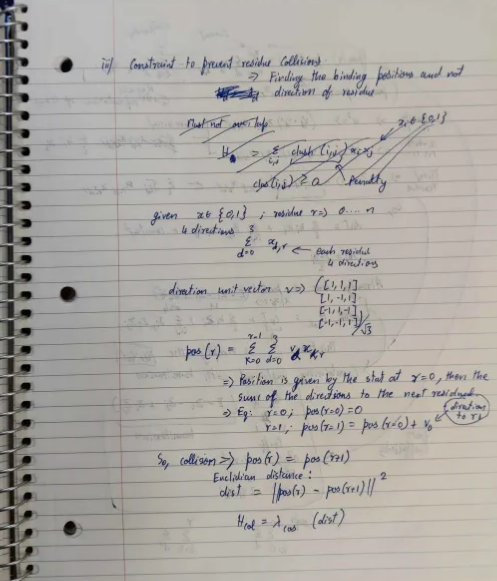
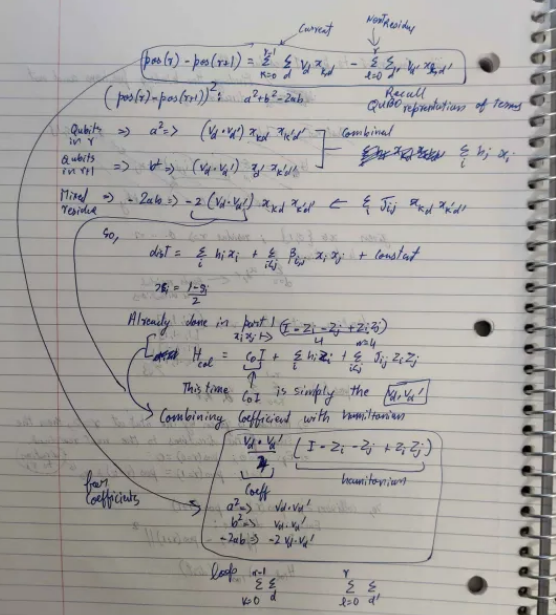

In [11]:
def collision_constraint(num_residue):
    num_qubits = num_residue * 4  # tetrahedral lattice
    lambda_col = 30.0

    dot_vvd = np.zeros((4,4))
    Coeffs = np.zeros((num_qubits,num_qubits))# the coefficient matrix
    pauli_Op = []

    # compute coefficients dot product
    for k in range(4):
        for kd in range(4):
            dot_vvd[k,kd] = np.dot(v[k],v[kd])


    # looping through all pos(r) and pos(r+1)
    # pos(r) - pos(r+1) = (sum(k = 0, to r-1) (sum(d)) vd xk,d) - (sum(l=r+1, to r) sum(d') vd' xl,d')
    # (sum(k = 0, to r-1)
    for r in range(num_residue-1):
        # - (sum(l=r+1, to r) 
        # making sure to exlude r from the comparisons
        for l in range(r+1, num_residue):

            # setting/summing coefficients
            # a.a = dot(vd. vd' ) for all sum(d) and sum(d'), d = directions
            for d in range(4): 
                for d2 in range(4):
                    # a.a  ==> pos(r). pos(r) = vd.vd' * xkd xld'
                    # get index for all r, l=r+1, with respective directions
                    i = r*4 + d
                    j = r*4 + d2
                    # adding since, this will be done fro all combinatinos of a2 + b2 -2ab
                    Coeffs[i,j] = Coeffs[i,j] + dot_vvd[d,d2]

            # setting/summing coefficients
            # a.a = dot(vd. vd' ) for all sum(d) and sum(d'), d = directions
            for d in range(4): 
                for d2 in range(4):
                    # a.a  ==> pos(r). pos(r) = vd.vd' * xkd xld'
                    # get index for all r, l=r+1, with respective directions
                    i = l*4 + d
                    j = l*4 + d2
                    # adding since, this will be done fro all combinatinos of a2 + b2 -2ab
                    Coeffs[i,j] = Coeffs[i,j] + dot_vvd[d,d2]



            # setting/summing coefficients
            # a.a = dot(vd. vd' ) for all sum(d) and sum(d'), d = directions
            for d in range(4): 
                for d2 in range(4):
                    # -2.a.b  ==> -2.pos(r). pos(r) = -2.vd.vd' * xkd xld'
                    # get index for all r, l=r+1, with respective directions
                    i = r*4 + d
                    j = l*4 + d2
                    # adding since, this will be done fro all combinatinos of a2 + b2 -2ab
                    Coeffs[i,j] = Coeffs[i,j] + (-2*dot_vvd[d,d2])


            # implemented Coefficients
            # for the Hamiltonian

            # This was necessary as makes it so that cij = cji
            # C = vd.vd'/2
            Coeffs = 0.5 * (Coeffs + Coeffs.T)

            Coeffs = Coeffs * lambda_col

            pauli_Op = []

            # Hamiltonian: I- Zi -Zj +ZiZj
            for i in range(num_qubits):
                for j in range(i+1, num_qubits):
                    Jij = Coeffs[i,j]

                    if Jij == 0:
                        continue

                    # for I 
                    pauli_Op.append(('I' * num_qubits, Jij))

                    # for -Zi
                    pauli = ['I'] * num_qubits
                    pauli[i] = 'Z'
                    pauli_Op.append((''.join(pauli), (-1*Jij)))

                    # for -Zi
                    pauli = ['I'] * num_qubits
                    pauli[j] = 'Z'
                    pauli_Op.append((''.join(pauli), (-1*Jij)))

                    # for ZiZj
                    pauli=['I']* num_qubits
                    pauli[i] = 'Z'
                    pauli[j] = 'Z'
                    pauli_Op.append((''.join(pauli), Jij))

    if not pauli_Op:
        return SparsePauliOp.from_list([('I'* max(1,num_qubits), 0.0)])

    return SparsePauliOp.from_list(pauli_Op)
    

In [12]:
Hcol = collision_constraint(2)
print(Hcol)

SparsePauliOp(['IIIIIIII', 'ZIIIIIII', 'IZIIIIII', 'ZZIIIIII', 'IIIIIIII', 'ZIIIIIII', 'IIZIIIII', 'ZIZIIIII', 'IIIIIIII', 'ZIIIIIII', 'IIIZIIII', 'ZIIZIIII', 'IIIIIIII', 'ZIIIIIII', 'IIIIZIII', 'ZIIIZIII', 'IIIIIIII', 'ZIIIIIII', 'IIIIIZII', 'ZIIIIZII', 'IIIIIIII', 'ZIIIIIII', 'IIIIIIZI', 'ZIIIIIZI', 'IIIIIIII', 'ZIIIIIII', 'IIIIIIIZ', 'ZIIIIIIZ', 'IIIIIIII', 'IZIIIIII', 'IIZIIIII', 'IZZIIIII', 'IIIIIIII', 'IZIIIIII', 'IIIZIIII', 'IZIZIIII', 'IIIIIIII', 'IZIIIIII', 'IIIIZIII', 'IZIIZIII', 'IIIIIIII', 'IZIIIIII', 'IIIIIZII', 'IZIIIZII', 'IIIIIIII', 'IZIIIIII', 'IIIIIIZI', 'IZIIIIZI', 'IIIIIIII', 'IZIIIIII', 'IIIIIIIZ', 'IZIIIIIZ', 'IIIIIIII', 'IIZIIIII', 'IIIZIIII', 'IIZZIIII', 'IIIIIIII', 'IIZIIIII', 'IIIIZIII', 'IIZIZIII', 'IIIIIIII', 'IIZIIIII', 'IIIIIZII', 'IIZIIZII', 'IIIIIIII', 'IIZIIIII', 'IIIIIIZI', 'IIZIIIZI', 'IIIIIIII', 'IIZIIIII', 'IIIIIIIZ', 'IIZIIIIZ', 'IIIIIIII', 'IIIZIIII', 'IIIIZIII', 'IIIZZIII', 'IIIIIIII', 'IIIZIIII', 'IIIIIZII', 'IIIZIZII', 'IIIIIIII', 'IIIZIIII', '

-----

### Math for interaction Collision

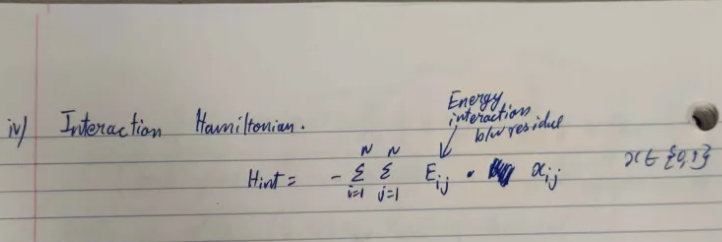

In [13]:
def interaction_constraint(num_residue):
    pass

-----

In [14]:
# for edge in edge_list: 
#     ham_list.append(("ZZ", edge, 0.5))
#     ham_list.append(("XX", edge, 0.5))
#     ham_list.append(("YY", edge, 0.5))

# for qubit in reduced_coupling.physical_qubits: 
#     ham_list.append(("Z", [qubit], np.random.random() * 2 -1))

# hamiltonian = SparsePauliOp.from_sparse_list(ham_list, num_qubits = num_spins)
# ansatz.draw("mpl", style = "iqp")

# Combining all the hamiltonians

In [15]:
# num of residue declared earlier
hc = one_hot_constraint(num_residue)
hg = geometric_constraint(num_residue)
hcol = collision_constraint(num_residue)
hamiltonian = hc + hg + hcol
print(hamiltonian)

SparsePauliOp(['IIIIIIII', 'ZIIIIIII', 'IZIIIIII', 'IIZIIIII', 'IIIZIIII', 'ZZIIIIII', 'ZIZIIIII', 'ZIIZIIII', 'IZZIIIII', 'IZIZIIII', 'IIZZIIII', 'IIIIZIII', 'IIIIIZII', 'IIIIIIZI', 'IIIIIIIZ', 'IIIIZZII', 'IIIIZIZI', 'IIIIZIIZ', 'IIIIIZZI', 'IIIIIZIZ', 'IIIIIIZZ', 'IIIIIIII', 'ZIIIIIII', 'IIIIZIII', 'ZIIIZIII', 'IIIIIIII', 'ZIIIIIII', 'IIIIIZII', 'ZIIIIZII', 'IIIIIIII', 'ZIIIIIII', 'IIIIIIZI', 'ZIIIIIZI', 'IIIIIIII', 'ZIIIIIII', 'IIIIIIIZ', 'ZIIIIIIZ', 'IIIIIIII', 'IZIIIIII', 'IIIIZIII', 'IZIIZIII', 'IIIIIIII', 'IZIIIIII', 'IIIIIZII', 'IZIIIZII', 'IIIIIIII', 'IZIIIIII', 'IIIIIIZI', 'IZIIIIZI', 'IIIIIIII', 'IZIIIIII', 'IIIIIIIZ', 'IZIIIIIZ', 'IIIIIIII', 'IIZIIIII', 'IIIIZIII', 'IIZIZIII', 'IIIIIIII', 'IIZIIIII', 'IIIIIZII', 'IIZIIZII', 'IIIIIIII', 'IIZIIIII', 'IIIIIIZI', 'IIZIIIZI', 'IIIIIIII', 'IIZIIIII', 'IIIIIIIZ', 'IIZIIIIZ', 'IIIIIIII', 'IIIZIIII', 'IIIIZIII', 'IIIZZIII', 'IIIIIIII', 'IIIZIIII', 'IIIIIZII', 'IIIZIZII', 'IIIIIIII', 'IIIZIIII', 'IIIIIIZI', 'IIIZIIZI', 'IIIIIIII', '

In [16]:
target = backend.target
# pm = generate_preset_pass_manager(optimization_level = 3, backend = backend)
ansatz_ibm = transpile(ansatz, backend=backend, optimization_level=3)

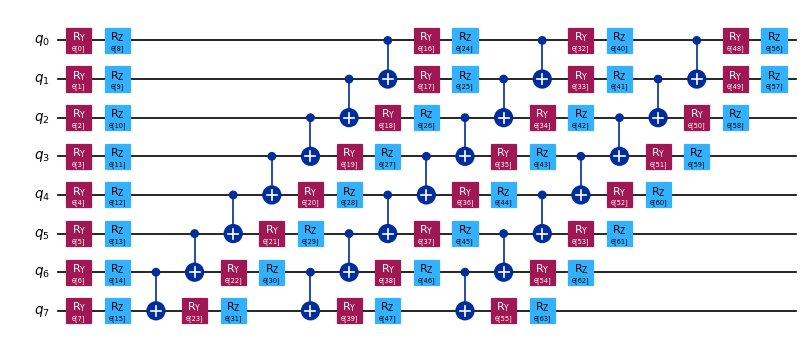

In [17]:
# this is unnecessary as you are not running on the IBM runtime
# pm.scheduling = PassManager(
#     [
#         ALAPScheduleAnalysis(durations = target.durations()),
#         PadDynamicalDecoupling(
#             durations = target.durations(),
#             dd_sequence = [XGate(), XGate()],
#             pulse_alignment = target.pulse_alignment, 
#         ),
#     ]
# )

observable_ibm =  hamiltonian.apply_layout(ansatz_ibm.layout)
ansatz_ibm.draw("mpl", scale = 0.6, style = "iqp", fold = -1, idle_wires = False)

In [18]:
def cost_func(params: Sequence, ansatz: QuantumCircuit, hamiltonian: SparsePauliOp, estimator: BaseEstimatorV2,) -> float:
    # Ground state energy evaluation
    return (estimator.run([(ansatz, hamiltonian, [params])]).result()[0].data.evs[0])

In [19]:
num_params = ansatz_ibm.num_parameters
params = 2 * np.pi * np.random.random(num_params)

callback_dict = {
    'prev_vector': None, 
    'iters': 0,
    'cost_history': [],
}

Iters. done: 563 [Current cost: -402.09107286063863]

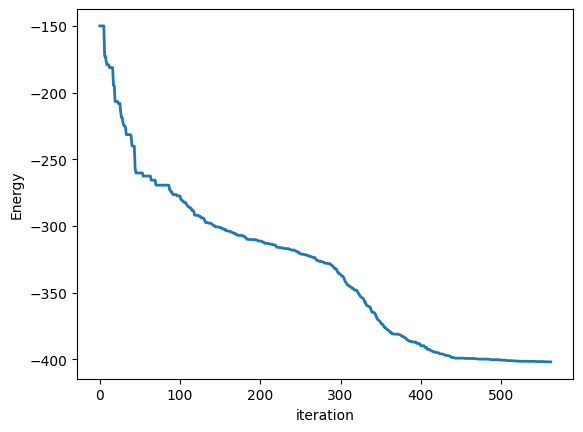

In [20]:
with Session(backend = backend) as sessino: 
    estimator = Estimator()
    callback = build_callback(ansatz_ibm,observable_ibm, estimator, callback_dict)
    res = minimize(
        cost_func, x0= params, 
        args = (ansatz_ibm, observable_ibm, estimator), 
        callback = callback, 
        method = "cobyla",
        options = {"maxiter":1000},
    )
visualize_results(callback_dict)

# Implmeenting it onto IONQ

In [21]:
# !pip install qiskit-ionq
# !setx ION_API_KEY "dont have an account"

In [22]:
# from qiskit_ionq import IonQProvider
# provider = IonQProvider(token = "API_KEY")
# backend = provider.get_backend("ionq_qpu")

In [23]:
# ionq estimator, uses EstimatorV2
# from qiskit_ibm_runtime import EstimatorV2